# Homework 3 - Jonathan Stumpf - EMSE 6992

#### Data Background and HW3 Summary

The following 10 instructions have been implemented on the Open AQ dataset:
    -  Model Selection
    -  Gaussian Process for Machine Learning
    -  Clustering
    -  Covariance Estimation
    -  Logistic Regression 3-Class Classifier
    -  Decomposition
    -  Outlier Detection
    -  Support Vector Machine
    -  Nearest Neighbors
    -  Semi Supervised Classification
    
Open AQ information: 
    -  ndjson datafiles downloaded from: https://openaq-fetches.s3.amazonaws.com/index.html
    -  Open AQ homepage: https://openaq.org/#/?_k=sl7cc2

#### Background Functions to Load & Clean Open AQ Data

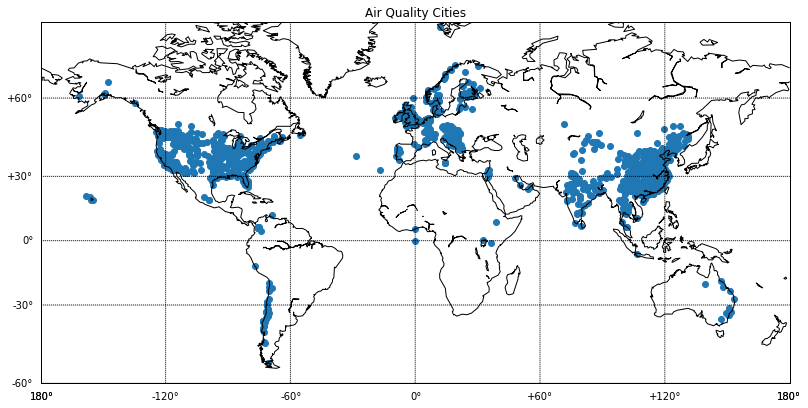

In [4]:
import ndjson
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def clean_dataframe(df_in):
    # drop the attribution column
    df_in.drop('attribution', axis=1, inplace=True)
    
    """Extract the latitude / longitude values from the nested coordinates dict"""
#    lat_list = [df_in.coordinates[i]["latitude"] for i in np.arange(0,df_in.shape[0])]
    lat_list = []
    lon_list = []
    for indx in np.arange(0,df_in.shape[0]):
        if type(df_in.coordinates[indx]) == float:
            lat_list.append(np.nan)
            lon_list.append(np.nan)
        else:
            lat_list.append(df_in.coordinates[indx]["latitude"])  
            lon_list.append(df_in.coordinates[indx]["longitude"])
                                     
    """Drop the coordinates column from the dataframe"""
    df_in.drop('coordinates',axis=1 , inplace=True)
    
    """Create lat/lon columns for the dataframe"""
    df_in['latitude'] = lat_list
    df_in['longitude'] = lon_list
    
    # extract averagePeriod details
#    ave_value_list = [df_in.averagingPeriod[i]["value"] for i in range(df_in.shape[0])]
    ave_value_list = []
    ave_unit_list = []
    for indx in np.arange(0,df_in.shape[0]):
        if type(df_in.averagingPeriod[indx]) == float:
            ave_value_list.append(np.nan)
            ave_unit_list.append(np.nan)
        else:
            ave_value_list.append(df_in.averagingPeriod[indx]["value"])
            ave_unit_list.append(df_in.averagingPeriod[indx]["unit"])
    
    df_in.drop('averagingPeriod', axis=1, inplace=True)
    
    df_in['ave_value'] = ave_value_list
    df_in['ave_unit'] = ave_unit_list
          
    return(df_in)
    
    
def consolidate_city_info(df_in):
    """Consolidate by city"""

    df_in.dropna(subset=['latitude', 'longitude'],inplace=True)

    """mask a mask for each possible measurement type"""
    meas_types = ['pm25', 'no2', 'o3', 'pm10', 'co', 'so2', 'bc']
    mask_meas_types = np.zeros([df_in.shape[0],len(meas_types)],dtype=bool)
    for i in range(len(meas_types)):
        mask_meas_types[:,i] = df_in.parameter == meas_types[i]    
#        curr_units = df_in['unit'][mask_meas_types[:,i]].unique()
#        print(f'{meas_types[i]}: {curr_units}\n')
#        if len(df_in['unit'][mask_meas_types[:,i]].unique()) > 1:

    """Consolidate"""
    info_dict = {}
    unq_cities = df_in.city.unique()
    num_cities = len(unq_cities)
    info_dict = {}
    info_dict['City'] = unq_cities
    mean_lat = []
    mean_lon = []
    country = []        
    pm25_present = []
    pm25_unit = []
    pm25_mean = []
    pm25_median = []
    no2_present = []
    no2_unit = []
    no2_mean = []
    no2_median = []
    o3_present = []
    o3_unit = []
    o3_mean = []
    o3_median = []
    pm10_present = []
    pm10_unit = []
    pm10_mean = []
    pm10_median = []
    co_present = []
    co_unit = []
    co_mean = []
    co_median = []
    so2_present = []
    so2_unit = []
    so2_mean = []
    so2_median = []
    bc_present = []
    bc_unit = []
    bc_mean = []
    bc_median = []
    
    for i in range(len(unq_cities)):
        curr_city_mask = df_in['city'] == unq_cities[i]
        mean_lat.append(df_in.latitude[curr_city_mask].mode()[0])
        mean_lon.append(df_in.longitude[curr_city_mask].mode()[0])
        country.append(df_in.country[curr_city_mask].unique()[0])
        for j in range(len(meas_types)):
            cur_city_meas_mask = mask_meas_types[:,j] & curr_city_mask
            curr_type = meas_types[j]
            if curr_type == 'pm25':
                if sum(cur_city_meas_mask):                            
                    pm25_present.append(True)
                    pm25_unit.append(df_in['unit'][cur_city_meas_mask].unique()[0])
                    pm25_mean.append(df_in['value'][cur_city_meas_mask].mean())
                    pm25_median.append(df_in['value'][cur_city_meas_mask].median())  
                else:
                    pm25_present.append(False)
                    pm25_unit.append(np.nan)
                    pm25_mean.append(np.nan)
                    pm25_median.append(np.nan)  
            elif curr_type == 'no2':
                if sum(cur_city_meas_mask):                            
                    no2_present.append(True)
                    no2_unit.append(df_in['unit'][cur_city_meas_mask].unique()[0])
                    no2_mean.append(df_in['value'][cur_city_meas_mask].mean())
                    no2_median.append(df_in['value'][cur_city_meas_mask].median())  
                else:
                    no2_present.append(False)
                    no2_unit.append(np.nan)
                    no2_mean.append(np.nan)
                    no2_median.append(np.nan)                      
            elif curr_type == 'o3':
                if sum(cur_city_meas_mask):                            
                    o3_present.append(True)
                    o3_unit.append(df_in['unit'][cur_city_meas_mask].unique()[0])
                    o3_mean.append(df_in['value'][cur_city_meas_mask].mean())
                    o3_median.append(df_in['value'][cur_city_meas_mask].median())  
                else:
                    o3_present.append(False)
                    o3_unit.append(np.nan)
                    o3_mean.append(np.nan)
                    o3_median.append(np.nan)    
            elif curr_type == 'pm10':
                if sum(cur_city_meas_mask):                            
                    pm10_present.append(True)
                    pm10_unit.append(df_in['unit'][cur_city_meas_mask].unique()[0])
                    pm10_mean.append(df_in['value'][cur_city_meas_mask].mean())
                    pm10_median.append(df_in['value'][cur_city_meas_mask].median())  
                else:
                    pm10_present.append(False)
                    pm10_unit.append(np.nan)
                    pm10_mean.append(np.nan)
                    pm10_median.append(np.nan)   
            elif curr_type == 'co':
                if sum(cur_city_meas_mask):                            
                    co_present.append(True)
                    co_unit.append(df_in['unit'][cur_city_meas_mask].unique()[0])
                    co_mean.append(df_in['value'][cur_city_meas_mask].mean())
                    co_median.append(df_in['value'][cur_city_meas_mask].median())  
                else:
                    co_present.append(False)
                    co_unit.append(np.nan)
                    co_mean.append(np.nan)
                    co_median.append(np.nan)   
            elif curr_type == 'so2':
                if sum(cur_city_meas_mask):                            
                    so2_present.append(True)
                    so2_unit.append(df_in['unit'][cur_city_meas_mask].unique()[0])
                    so2_mean.append(df_in['value'][cur_city_meas_mask].mean())
                    so2_median.append(df_in['value'][cur_city_meas_mask].median())  
                else:
                    so2_present.append(False)
                    so2_unit.append(np.nan)
                    so2_mean.append(np.nan)
                    so2_median.append(np.nan)   
            elif curr_type == 'bc':
                if sum(cur_city_meas_mask):                            
                    bc_present.append(True)
                    bc_unit.append(df_in['unit'][cur_city_meas_mask].unique()[0])
                    bc_mean.append(df_in['value'][cur_city_meas_mask].mean())
                    bc_median.append(df_in['value'][cur_city_meas_mask].median())  
                else:
                    bc_present.append(False)
                    bc_unit.append(np.nan)
                    bc_mean.append(np.nan)
                    bc_median.append(np.nan)   
            
    info_dict['Latitude'] = mean_lat
    info_dict['Longitude'] = mean_lon
    info_dict['Country'] = country
    info_dict['City'] = unq_cities
    info_dict['pm25_present'] = pm25_present
    info_dict['pm25_unit'] = pm25_unit
    info_dict['pm25_mean'] = pm25_mean
    info_dict['pm25_median'] = pm25_median
    info_dict['no2_present'] = no2_present
    info_dict['no2_unit'] = no2_unit
    info_dict['no2_mean'] = no2_mean
    info_dict['no2_median'] = no2_median
    info_dict['o3_present'] = o3_present
    info_dict['o3_unit'] = o3_unit
    info_dict['o3_mean'] = o3_mean
    info_dict['o3_median'] = o3_median
    info_dict['pm10_present'] = pm10_present
    info_dict['pm10_unit'] = pm10_unit
    info_dict['pm10_mean'] = pm10_mean
    info_dict['pm10_median'] = pm10_median
    info_dict['co_present'] = co_present
    info_dict['co_unit'] = co_unit
    info_dict['co_mean'] = co_mean
    info_dict['co_median'] = co_median
    info_dict['so2_present'] = so2_present
    info_dict['so2_unit'] = so2_unit
    info_dict['so2_mean'] = so2_mean
    info_dict['so2_median'] = so2_median
    info_dict['bc_present'] = bc_present
    info_dict['bc_unit'] = bc_unit
    info_dict['bc_mean'] = bc_mean
    info_dict['bc_median'] = bc_median
       
    new_df = pd.DataFrame(info_dict)
    return new_df


geo_plot_bool = True

# set a test path
test_dir = 'open_aq_data\\'
if os.path.exists(test_dir):
    dir_files = os.listdir(test_dir)
else:
    print(f'Not a valid directory: {test_dir}')

# clean up the directory to just .ndjson files
dir_files = [test_dir + file for file in dir_files if os.path.splitext(file)[1] == '.ndjson']

# iterate through each file, read ndjson into a list, concatinate list
data = []
for curr_file in dir_files:
    with open(curr_file, encoding='utf-8') as ndjson_file:
        curr_data = ndjson.load(ndjson_file)
    # concatinate data
    data += curr_data

data = pd.DataFrame(data)

data = clean_dataframe(data)

# print the unique parameters
unq_meas_type = data.parameter.unique()
meas_type = {}
# count the measurement types in the dataset
for i in range(len(unq_meas_type)):
    mask_curr_meas_type = data.parameter == unq_meas_type[i]
    meas_type.update({unq_meas_type[i]:sum(mask_curr_meas_type)})


# save the data out to a csv
data.to_csv('open_aq.csv')

city_df = consolidate_city_info(data)
city_df.dropna(subset=['Latitude', 'Longitude'],inplace=True)

city_df.Country.unique()
mask_us = city_df['Country'] == 'US'

if geo_plot_bool:
    fig = plt.figure(figsize=(13,13))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # lon_0 is central longitude of projection.
    # resolution = 'c' means use crude resolution coastlines.
    m = Basemap(llcrnrlon=-180.,llcrnrlat=-60.,urcrnrlon=180.,urcrnrlat=80.,\
                projection='mill')
    m.drawcoastlines()
#    m.drawstates()
#    m.fillcontinents(color='coral',lake_color='aqua')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-60,90,30),labels=[1,0,0,0],labelstyle='+/-')
    m.drawmeridians(np.arange(0.,360.,60.),labels=[0,0,0,1],labelstyle='+/-')
    m.drawmapboundary()
    m.scatter(city_df['Longitude'].values,city_df['Latitude'].values,latlon=True)
#    m.scatter(city_df['Longitude'][mask_us].values,city_df['Latitude'][mask_us].values,latlon=True)
    plt.title("Air Quality Cities")
    plt.show()

    sum(mask_us)
    
city_df.to_csv('openAQ_city_df.csv')    
print('done')

#### Scratch-work Cell for Dataframe Edits / Masking

In [8]:
city_df = pd.read_csv('openAQ_city_df.csv')
city_df.drop(['Unnamed: 0'],axis=1,inplace=True)

# city_df.head()

# for exercise 9
# print(f'pm25: {sum(city_df.pm25_present)}')
# print(f'no2: {sum(city_df.no2_present)}')
# print(f'co: {sum(city_df.co_present)}')
# print(f'so2: {sum(city_df.so2_present)}')
# print(f'bc: {sum(city_df.bc_present)}')

mask_pm25_ugm3 = (city_df.pm25_unit == 'µg/m³')
mask_no2_ugm3 = (city_df.no2_unit == 'µg/m³')
mask_co_ugm3 =(city_df.co_unit == 'µg/m³')

mask_pm25_no2 = (city_df.pm25_present & mask_pm25_ugm3) &\
                (city_df.no2_present & mask_no2_ugm3)
mask_pm25_no2_co = (city_df.pm25_present & mask_pm25_ugm3) &\
                    (city_df.no2_present & mask_no2_ugm3) &\
                    (city_df.co_present & mask_co_ugm3)
# print(f'pm25 & no2: {sum(mask_pm25_no2)}')
# print(f'pm25 & no2 & co: {sum(mask_pm25_no2_co)}')

mask_pos_pm25 = city_df.pm25_mean >= 0
mask_pos_no2 = city_df.no2_mean >= 0
mask_pos_co = city_df.co_mean >= 0

df_pm25_no2 = city_df[mask_pm25_no2 & (mask_pos_pm25 & mask_pos_no2)]
df_pm25_no2_co = city_df[mask_pm25_no2_co & (mask_pos_pm25 & mask_pos_no2 & mask_pos_co)]
# print(f'pm25 & no2: {df_pm25_no2.shape[0]}')
# print(f'pm25 & no2 & co: {df_pm25_no2_co.shape[0]}')
# create a divider for the data at 60 degrees longitude: Europe_and_SouthAmerica & Asia
mask_euro = df_pm25_no2.Longitude < 60
# print(sum(mask_euro))
mask_asia = df_pm25_no2.Longitude > 60
# print(sum(mask_asia))

mask_euro_3 = df_pm25_no2_co.Longitude < 60
# print(sum(mask_euro))
mask_asia_3 = df_pm25_no2_co.Longitude > 60
# print(sum(mask_asia))

# create additional geo boundaries to divide the data into 3s
mask_euro_2 = (df_pm25_no2.Longitude < 60) & (df_pm25_no2.Longitude > -60)
# print(f'Europe: {sum(mask_euro_2)}')
mask_w_asia_2 = (df_pm25_no2.Longitude >= 60) & (df_pm25_no2.Longitude < 110)
# print(f'Western Asia: {sum(mask_w_asia_2)}')
mask_e_asia_2 = (df_pm25_no2.Longitude >= 110) 
# print(df_pm25_no2.shape)
# print(f'Eastern Asia: {sum(mask_e_asia_2)}')
df_pm25_no2 = df_pm25_no2[mask_euro_2 | mask_w_asia_2 | mask_e_asia_2]
# print(df_pm25_no2.shape)
# create additional geo boundaries to divide the data into 3s
mask_euro_2 = (df_pm25_no2.Longitude < 60) & (df_pm25_no2.Longitude > -60)
# print(f'Europe: {sum(mask_euro_2)}')
mask_w_asia_2 = (df_pm25_no2.Longitude >= 60) & (df_pm25_no2.Longitude < 110)
# print(f'Western Asia: {sum(mask_w_asia_2)}')
mask_e_asia_2 = (df_pm25_no2.Longitude >= 110) 

# plt.plot(df_pm25_no2.pm25_mean, 'ro')
# plt.show()
# plt.plot(df_pm25_no2.no2_mean, 'ro')
# plt.show()
# plt.plot(df_pm25_no2_co.co_mean, 'ro')
# plt.show()

# print(sum(df_pm25_no2.pm25_mean >= 0))
# print(sum(df_pm25_no2.no2_mean >= 0))
# print('done')
# df_pm25_no2.head()
# df_pm25_no2_co.head()
# print(df_pm25_no2['Longitude'])


# # visualize the remaining cities
# fig = plt.figure(figsize=(13,13))
# ax = fig.add_axes([0.1,0.1,0.8,0.8])
# # lon_0 is central longitude of projection.
# # resolution = 'c' means use crude resolution coastlines.
# m = Basemap(llcrnrlon=-180.,llcrnrlat=-60.,urcrnrlon=180.,urcrnrlat=80.,\
#             projection='mill')
# m.drawcoastlines()
# #    m.drawstates()
# #    m.fillcontinents(color='coral',lake_color='aqua')
# # draw parallels and meridians.
# m.drawparallels(np.arange(-60,90,30),labels=[1,0,0,0],labelstyle='+/-')
# m.drawmeridians(np.arange(0.,360.,60.),labels=[0,0,0,1],labelstyle='+/-')
# m.drawmapboundary()
# m.scatter(city_df['Longitude'].values,city_df['Latitude'].values,latlon=True)
# #    m.scatter(city_df['Longitude'][mask_us].values,city_df['Latitude'][mask_us].values,latlon=True)
# plt.title("Air Quality Cities")
# plt.show()

# for exercise 10
# print(sum(city_df['Longitude'].isna()))
# print(city_df[city_df.pm25_present]['pm25_unit'].unique())
# mask_microgram_m3 = 
# df_pm25 = city_df[city_df.pm25_present]
# df_pm25.head()


#### (1) Outlier Detection

Text(0.5,0,'Absolute Latitude (deg)')

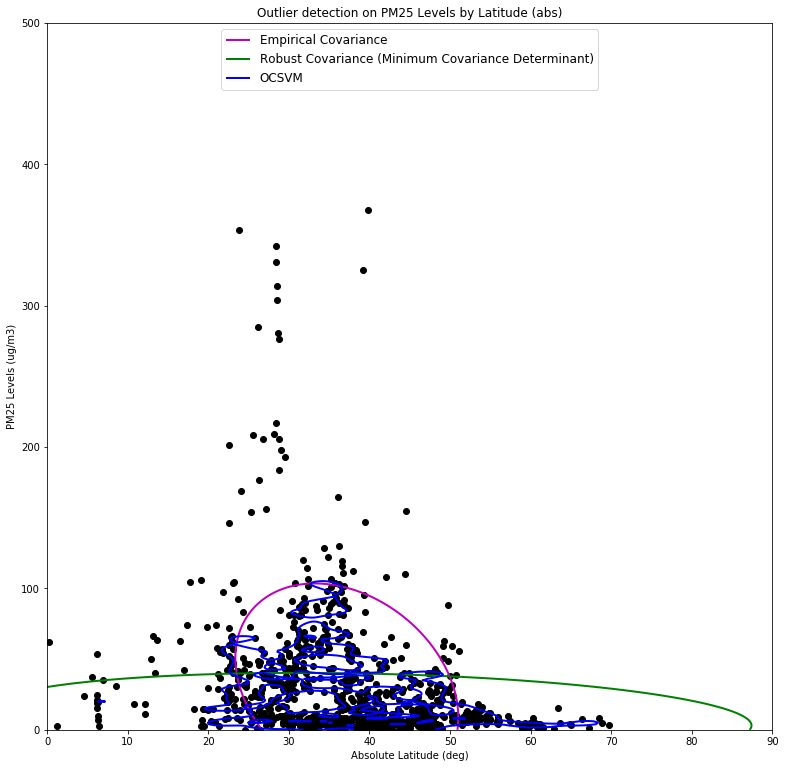

In [9]:
import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.font_manager


# for this exercise, filter the AQ data down to PM25 only
df_pm25 = city_df[city_df.pm25_present]
X1 = np.ndarray([df_pm25.shape[0],2])
X1[:,0] = abs(df_pm25['Latitude']) 
X1[:,1] = df_pm25['pm25_median']

median_y = np.median(X1[:,1])
std_y = X1[:,1].std()

classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                             contamination=0.261),
    "Robust Covariance (Minimum Covariance Determinant)":
    EllipticEnvelope(contamination=0.261),
    "OCSVM": OneClassSVM(nu=0.261, gamma=0.05)}
colors = ['m', 'g', 'b']
legend1 = {}
# change xx1 to represent [0,90] latitude degress (i.e. distance from the equator)
# change yy1 to represent [-3.5std,+3.5std] pm25 ug/m3
xx1, yy1 = np.meshgrid(np.linspace(0, 90, 500), np.linspace(0,500, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
#     print(clf_name)
#     print(clf)
    plt.figure(1,figsize=(13,13))
    clf.fit(X1)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])
    
legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

# Plot the results (= shape of the data points cloud)
plt.figure(1)  # two clusters
plt.title("Outlier detection on PM25 Levels by Latitude (abs)")
plt.scatter(X1[:, 0], X1[:, 1], color='black')
# bbox_args = dict(boxstyle="round", fc="0.8")
# arrow_args = dict(arrowstyle="->")
# plt.annotate("several confounded points", xy=(24, 19),
#              xycoords="data", textcoords="data",
#              xytext=(13, 10), bbox=bbox_args, arrowprops=arrow_args)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("PM25 Levels (ug/m3)")
plt.xlabel("Absolute Latitude (deg)")

#### (2) Decomposition

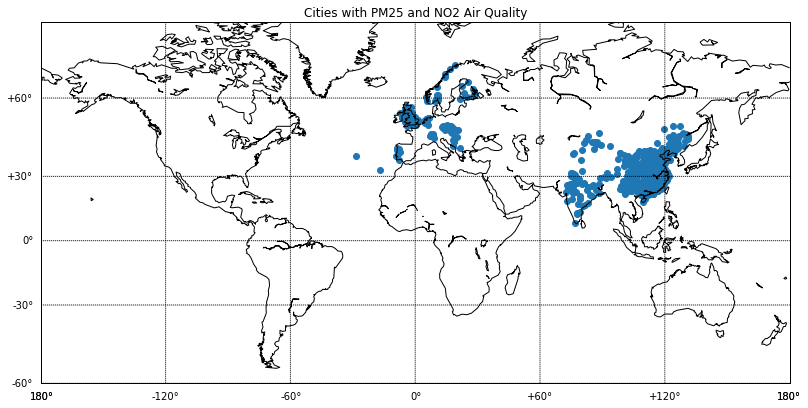

(571, 2)
(571, 1)
explained variance ratio (first two components): [0.89377035 0.10622965]


Text(0.5,1,'PCA of PM25 & NO2 Air Quality')

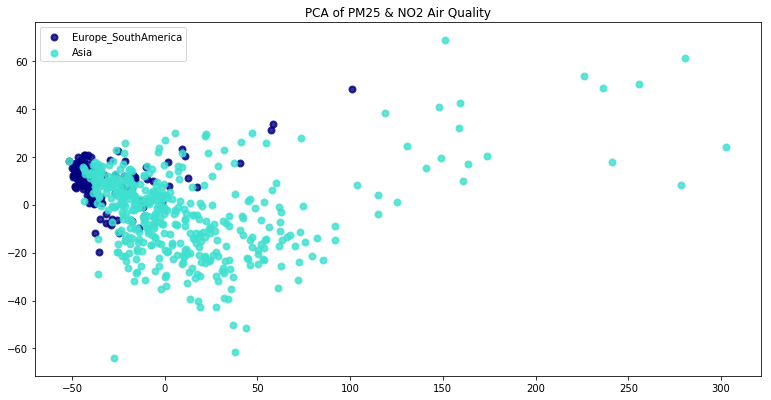

In [10]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# # shape AQ data into cities that have multiple AQ measurements (all with units ug/m3)
# mask_pm25_ugm3 = (city_df.pm25_unit == 'µg/m³')
# mask_no2_ugm3 = (city_df.no2_unit == 'µg/m³')
# mask_co_ugm3 =(city_df.co_unit == 'µg/m³')

# mask_pm25_no2 = (city_df.pm25_present & mask_pm25_ugm3) &\
#                 (city_df.no2_present & mask_no2_ugm3)
# mask_pm25_no2_co = (city_df.pm25_present & mask_pm25_ugm3) &\
#                     (city_df.no2_present & mask_no2_ugm3) &\
#                     (city_df.co_present & mask_co_ugm3)
# # print(f'pm25 & no2: {sum(mask_pm25_no2)}')
# # print(f'pm25 & no2 & co: {sum(mask_pm25_no2_co)}')

# df_pm25_no2 = city_df[mask_pm25_no2]
# df_pm25_no2_co = city_df[mask_pm25_no2_co]

# visualize the remaining cities
fig = plt.figure(figsize=(13,13))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(llcrnrlon=-180.,llcrnrlat=-60.,urcrnrlon=180.,urcrnrlat=80.,\
            projection='mill')
m.drawcoastlines()
#    m.drawstates()
#    m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-60,90,30),labels=[1,0,0,0],labelstyle='+/-')
m.drawmeridians(np.arange(0.,360.,60.),labels=[0,0,0,1],labelstyle='+/-')
m.drawmapboundary()
m.scatter(df_pm25_no2['Longitude'].values,df_pm25_no2['Latitude'].values,latlon=True)
#    m.scatter(city_df['Longitude'][mask_us].values,city_df['Latitude'][mask_us].values,latlon=True)
plt.title("Cities with PM25 and NO2 Air Quality")
plt.show()

# create a divider for the data at 60 degrees longitude: Europe_and_SouthAmerica & Asia
mask_euro = df_pm25_no2.Longitude < 60
# print(sum(mask_euro))
mask_asia = df_pm25_no2.Longitude > 60
# print(sum(mask_asia))


X = np.ndarray([df_pm25_no2.shape[0],2])
y = np.ndarray([df_pm25_no2.shape[0],])
X[:,0] = df_pm25_no2['pm25_median']
X[:,1] = df_pm25_no2['no2_median']
y[mask_euro] = 0
y[mask_asia] = 1

target_names = ['Europe_SouthAmerica', 'Asia']

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)
print(X_r.shape)
print(X_r2.shape)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))


### PMT Unconstrained
plt.figure(figsize=(13,6.5))
colors = ['navy', 'turquoise']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of PM25 & NO2 Air Quality')

### PMT Zoomed
# plt.figure(figsize=(13,6.5))
# colors = ['navy', 'turquoise']
# lw = 2

# for color, i, target_name in zip(colors, [0, 1, 2], target_names):
#     plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
#                 label=target_name)
# plt.legend(loc='best', shadow=False, scatterpoints=1)
# plt.xlim(-300,200)
# plt.ylim(-300,200)

# plt.title('PCA of PM25 & NO2 Air Quality (Zoomed)')

#### (3)  Logistic Regression 3-class Classifier

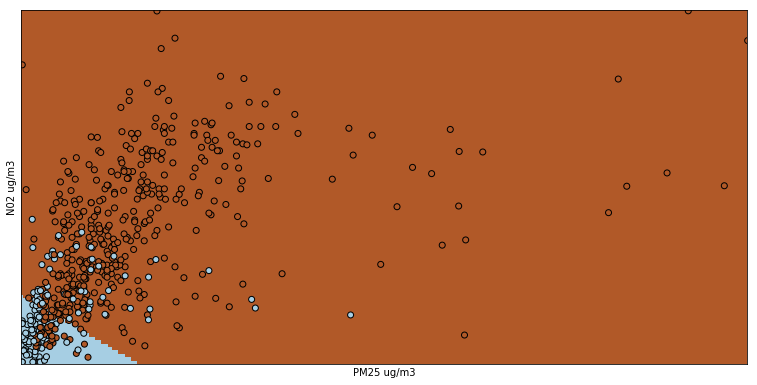

done


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets



X = np.ndarray([df_pm25_no2.shape[0],2])
Y = np.ndarray([df_pm25_no2.shape[0],])
X[:,0] = df_pm25_no2['pm25_median']
X[:,1] = df_pm25_no2['no2_median']
Y[mask_euro] = 0
Y[mask_asia] = 1

# target_names = ['Europe_SouthAmerica', 'Asia']

h = 1  # step size in the mesh

logreg = linear_model.LogisticRegression(C=1e5)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(13,6.5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('PM25 ug/m3')
plt.ylabel('N02 ug/m3')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()
print('done')

#### (4) Covariance Estimation

Automatically created module for IPython interactive environment


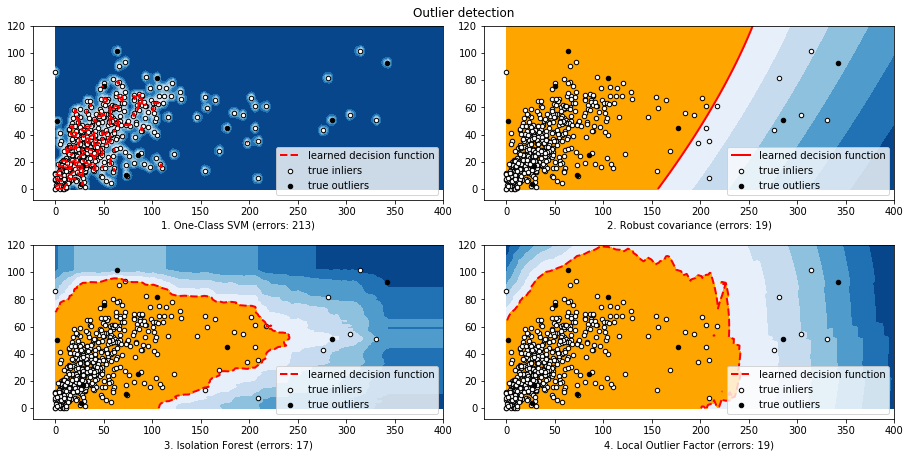

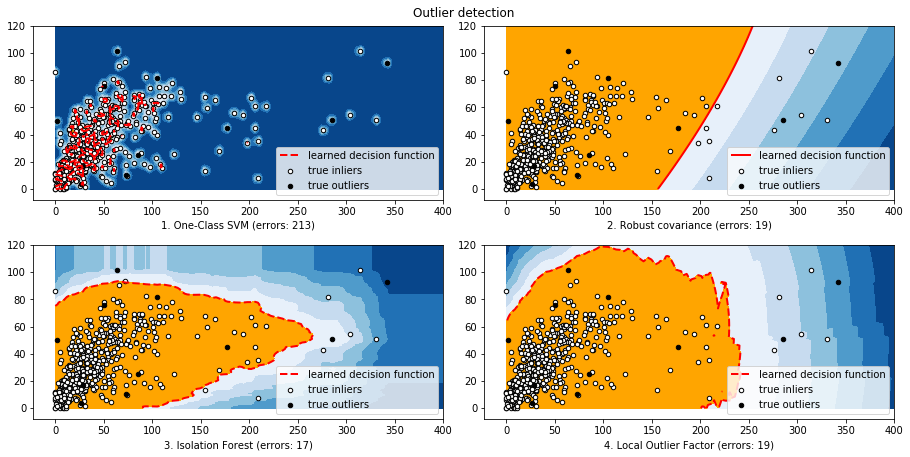

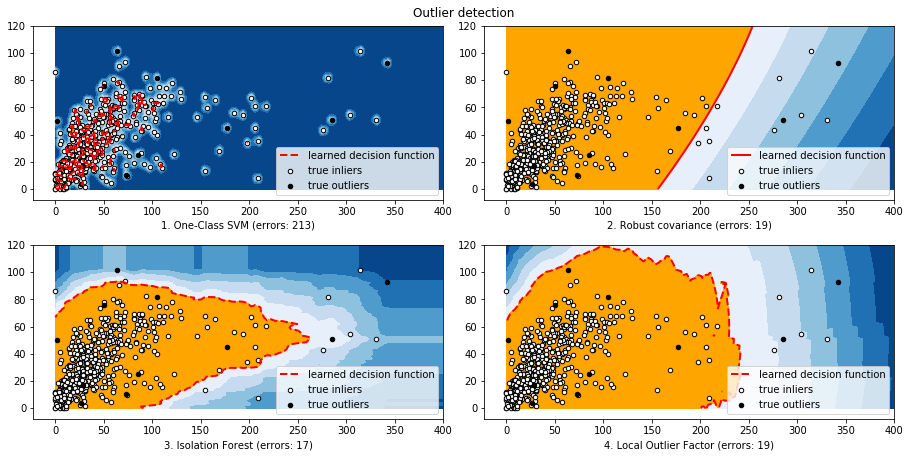

done


In [12]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

rng = np.random.RandomState(42)

X = np.ndarray([df_pm25_no2.shape[0],2])
#     Y = np.ndarray([df_pm25_no2.shape[0],])
X[:,0] = df_pm25_no2['pm25_median']
X[:,1] = df_pm25_no2['no2_median']

# Example settings
n_samples = X.shape[0]
outliers_fraction = 0.02
clusters_separation = [0, 1, 2]
# clusters_separation = [0]

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples,
                                        contamination=outliers_fraction,
                                        random_state=rng),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=35,
        contamination=outliers_fraction)}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(0, 400, 100), np.linspace(0, 120, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    
    # Fit the model
    plt.figure(figsize=(13, 6.5))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        if clf_name == "Local Outlier Factor":
            y_pred = clf.fit_predict(X)
            scores_pred = clf.negative_outlier_factor_
        else:
            clf.fit(X)
            scores_pred = clf.decision_function(X)
            y_pred = clf.predict(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
#         print(y_pred)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        if clf_name == "Local Outlier Factor":
            # decision_function is private for LOF
            Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(2, 2, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
#         subplot.set_xlim((-7, 7))
#         subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")

plt.show()
print('done')

#### (5) Clustering

431
46
26.879170815821734
19.125856020284782
52.71602088167053
37.6769837587007


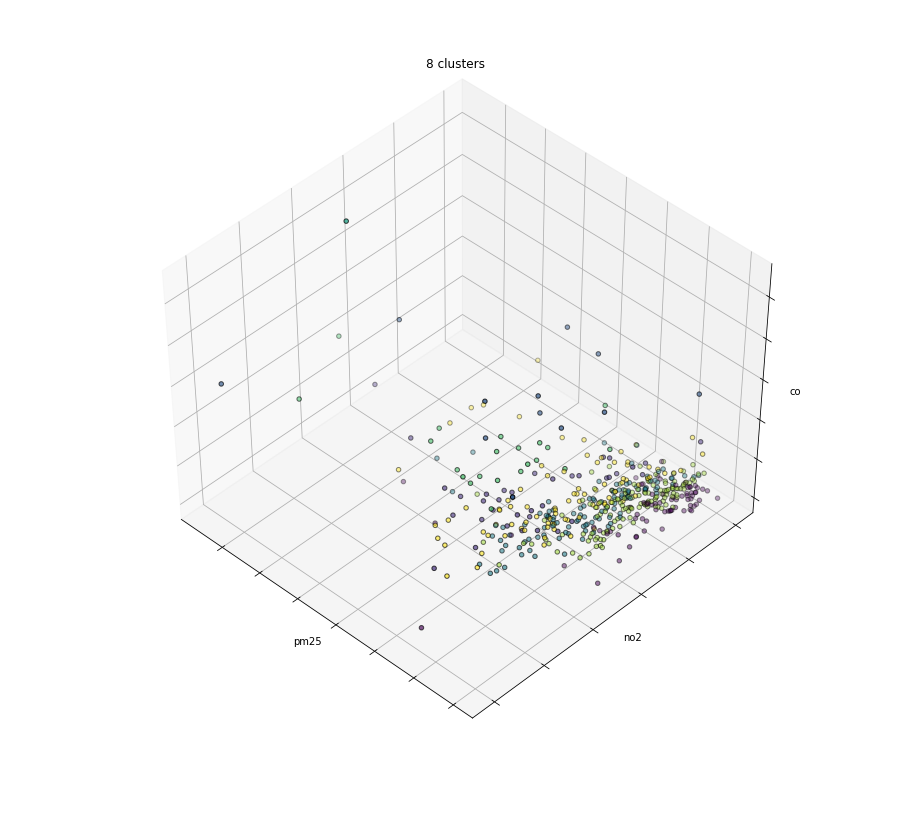

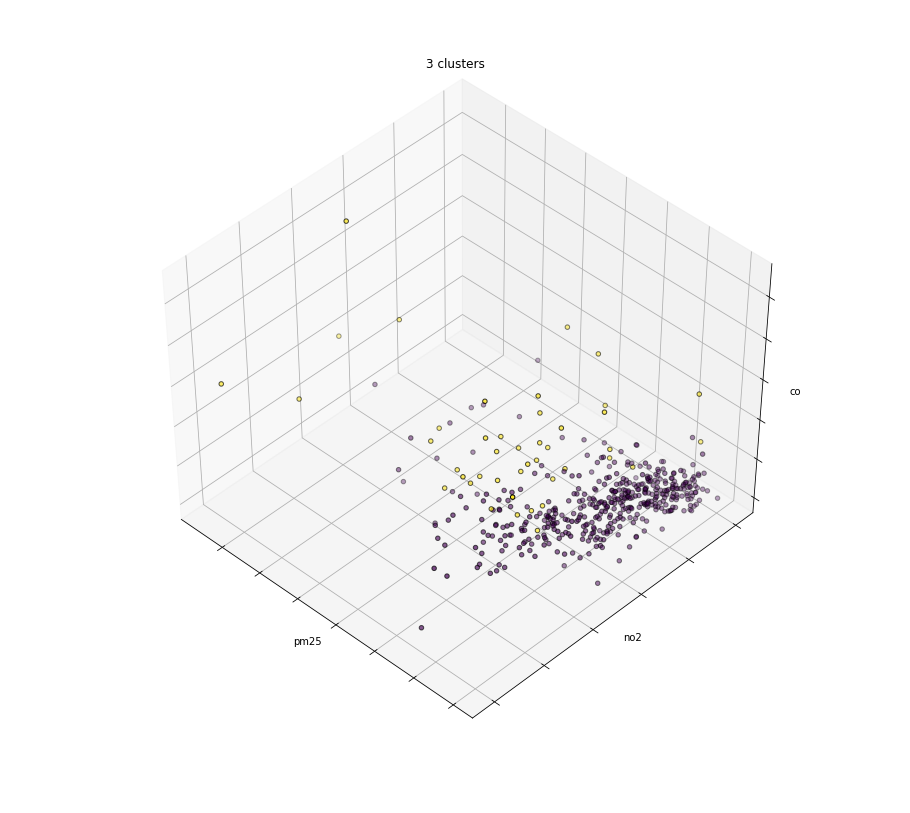

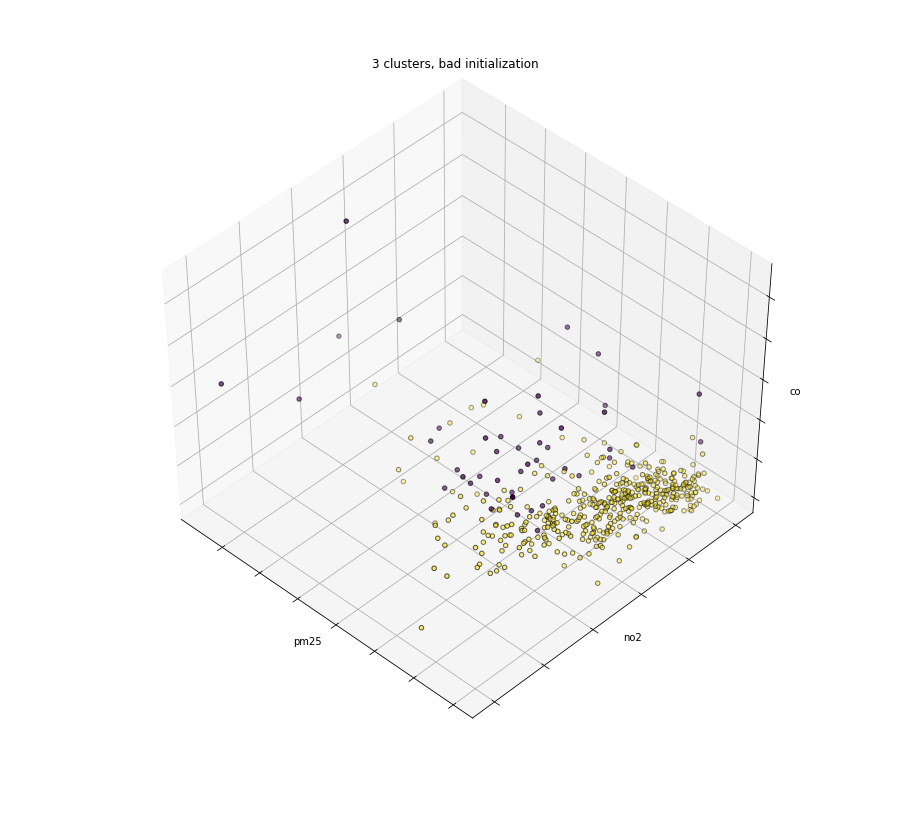

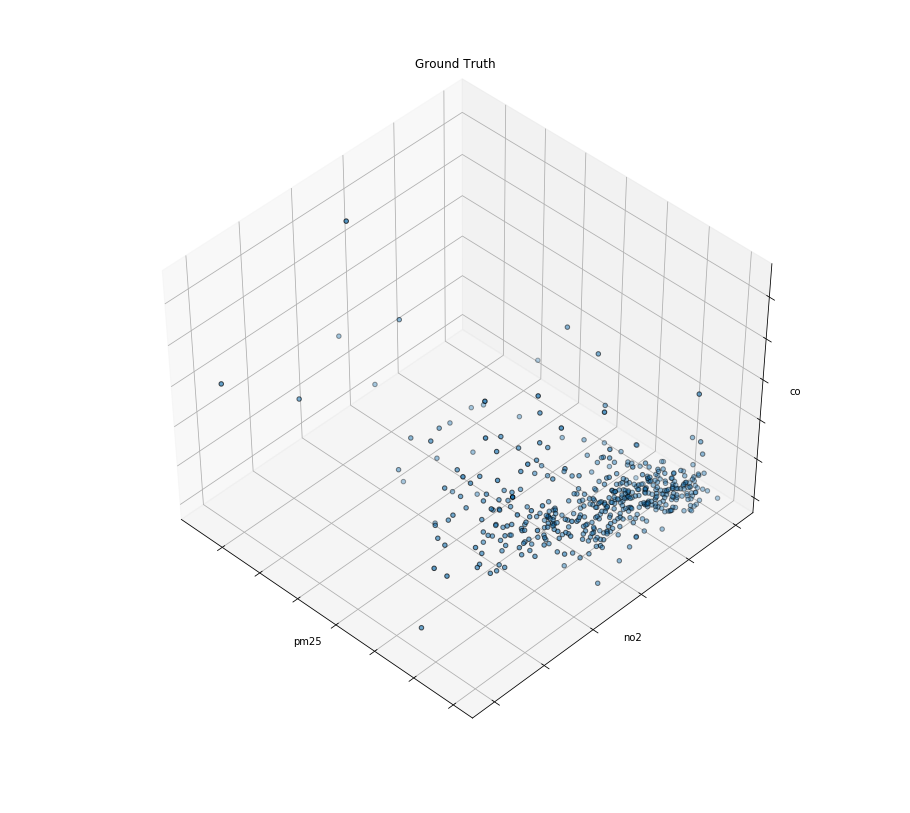

In [13]:
import numpy as np
import matplotlib.pyplot as plt
# Though the following import is not directly being used, it is required
# for 3D projection to work
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import datasets

np.random.seed(5)

# iris = datasets.load_iris()
# X = iris.data
# y = iris.target
X = np.ndarray([df_pm25_no2_co.shape[0],3])
# Y = np.ndarray([df_pm25_no2.shape[0],])
X[:,0] = df_pm25_no2_co['pm25_median']
X[:,1] = df_pm25_no2_co['no2_median']
X[:,2] = df_pm25_no2_co['co_median']
y = np.ndarray([df_pm25_no2_co.shape[0],])
y[mask_euro_3] = 0
y[mask_asia_3] = 1


estimators = [('k_means_iris_8', KMeans(n_clusters=8)),
              ('k_means_iris_3', KMeans(n_clusters=2)),
              ('k_means_iris_bad_init', KMeans(n_clusters=2, n_init=1,
                                               init='random'))]

fignum = 1
titles = ['8 clusters', '3 clusters', '3 clusters, bad initialization']
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(13,11))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 0], X[:, 1], X[:, 2],
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('pm25')
    ax.set_ylabel('no2')
    ax.set_zlabel('co')
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

# Plot the ground truth
fig = plt.figure(fignum, figsize=(13,11))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
print(sum(y==1))
print(sum(y==0))
# for name, label in [('Europe_SouthAmerica', 0),
#                     ('Asia', 1)]:
#     ax.text3D(X[y == label, 0].mean(),
#               X[y == label, 1].mean(),
#               X[y == label, 2].mean() + 2, name,
#               horizontalalignment='center',
#               bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
# # Reorder the labels to have colors matching the cluster results
# y = y.astype(np.float)
# y = np.choose(y, [0,1]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], edgecolor='k')

print(X[y == 0, 0].mean())
print(X[y == 0, 1].mean())
print(X[y == 1, 0].mean())
print(X[y == 1, 1].mean())


ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('pm25')
ax.set_ylabel('no2')
ax.set_zlabel('co')
ax.set_title('Ground Truth')
ax.dist = 12

#### (6) Gaussian Process for Machine Learning

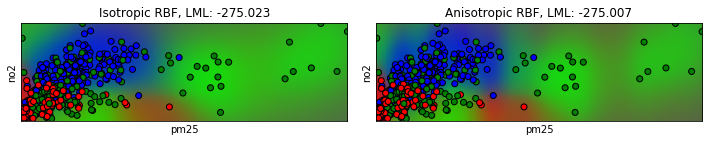

done


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

X = np.ndarray([df_pm25_no2.shape[0],2])
y = np.ndarray([df_pm25_no2.shape[0],],dtype=np.int64)
X[:,0] = df_pm25_no2['pm25_median']
X[:,1] = df_pm25_no2['no2_median']
y[mask_euro_2] = 0
y[mask_w_asia_2] = 1
y[mask_e_asia_2] = 2

h = 1  # step size in the mesh

kernel = 1.0 * RBF([1.0])
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)
kernel = 1.0 * RBF([1.0, 1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

titles = ["Isotropic RBF", "Anisotropic RBF"]
plt.figure(figsize=(10, 5))
for i, clf in enumerate((gpc_rbf_isotropic, gpc_rbf_anisotropic)):
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(1, 2, i + 1)

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
    plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=np.array(["r", "g", "b"])[y],
                edgecolors=(0, 0, 0))
    plt.xlabel('pm25')
    plt.ylabel('no2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title("%s, LML: %.3f" %
              (titles[i], clf.log_marginal_likelihood(clf.kernel_.theta)))

plt.tight_layout()
plt.show()
print('done')

#### (7) Model Selection

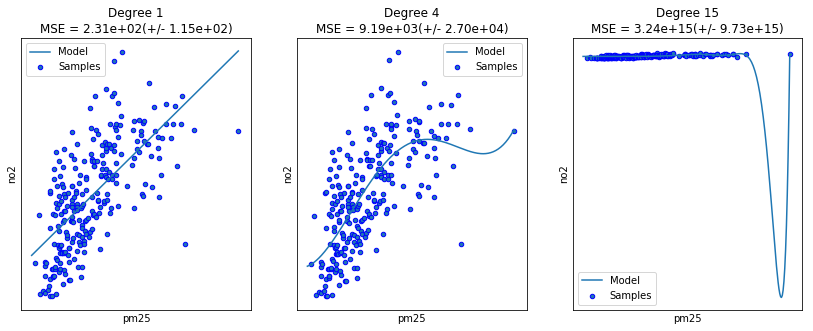

done


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


# def true_fun(X):
#     return np.cos(1.5 * np.pi * X)

np.random.seed(0)

# n_samples = 30
degrees = [1, 4, 15]

# X = np.sort(np.random.rand(n_samples))
# y = true_fun(X) + np.random.randn(n_samples) * 0.1

X = df_pm25_no2['pm25_median'][mask_e_asia_2].values
y = df_pm25_no2['no2_median'][mask_e_asia_2].values
# print(X)
sort_indx = np.argsort(X)
# print(sort_indx)

X = X[sort_indx]
y = y[sort_indx]
# print(X)
max_x = np.max(X)
# print(max_x)

X_test = np.sort(X)

# print(type(X))
# print(type(y))

# print(X)
# print(y)

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, max_x, 250)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
#     plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
#     plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("pm25")
    plt.ylabel("no2")
#     plt.xlim((0, 1))
#     plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()
print('done')

#### (8) Support Vector Machine

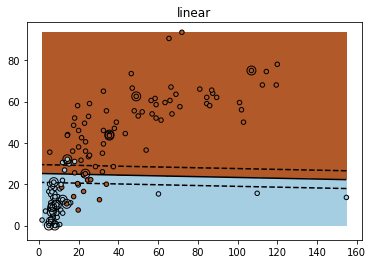

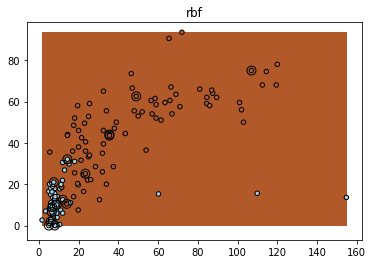

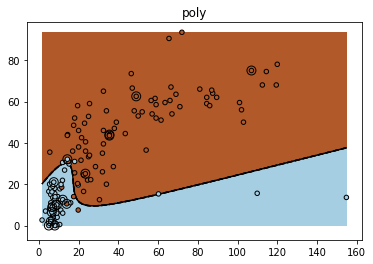

done


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm

X = np.ndarray([df_pm25_no2.shape[0],2])
y = np.ndarray([df_pm25_no2.shape[0],])
y[mask_w_asia_2] = 0
y[mask_euro_2] = 1
y[mask_e_asia_2] = 2
X[:,0] = df_pm25_no2['pm25_median']
X[:,1] = df_pm25_no2['no2_median']
X = X[y != 0, :2]
y = y[y != 0]
# print(y)

# downsample the data for speed
X = X[0:150,:]
y = y[0:150]
# print(X.shape)

n_sample = len(X)
# print(n_sample)

np.random.seed(0)
order = np.random.permutation(n_sample)
X = X[order]
y = y[order].astype(np.float)

X_train = X[:int(.9 * n_sample)]
y_train = y[:int(.9 * n_sample)]
X_test = X[int(.9 * n_sample):]
y_test = y[int(.9 * n_sample):]

# fit the model
for fig_num, kernel in enumerate(('linear', 'rbf', 'poly')):
    clf = svm.SVC(kernel=kernel, gamma=10)
    clf.fit(X_train, y_train)

    plt.figure(fig_num)
    plt.clf()
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    # Circle out the test data
    plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none',
                zorder=10, edgecolor='k')

    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title(kernel)
plt.show()
print('done')

#### (9) Nearest Neighbors

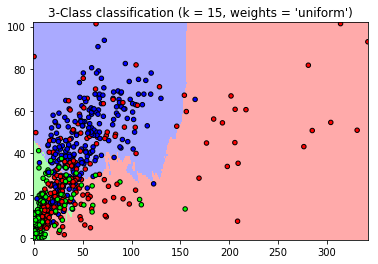

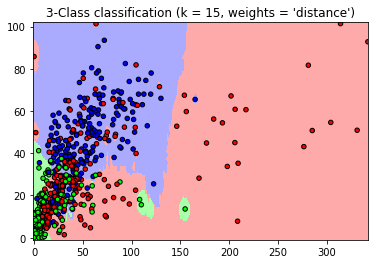

done


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
# X = iris.data[:, :2]
# y = iris.target

X = np.ndarray([df_pm25_no2.shape[0],2])
y = np.ndarray([df_pm25_no2.shape[0],])
y[mask_w_asia_2] = 0
y[mask_euro_2] = 1
y[mask_e_asia_2] = 2
X[:,0] = df_pm25_no2['pm25_median']
X[:,1] = df_pm25_no2['no2_median']

h = 1  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()
print('done')

#### (10) Semi Supervised Classification

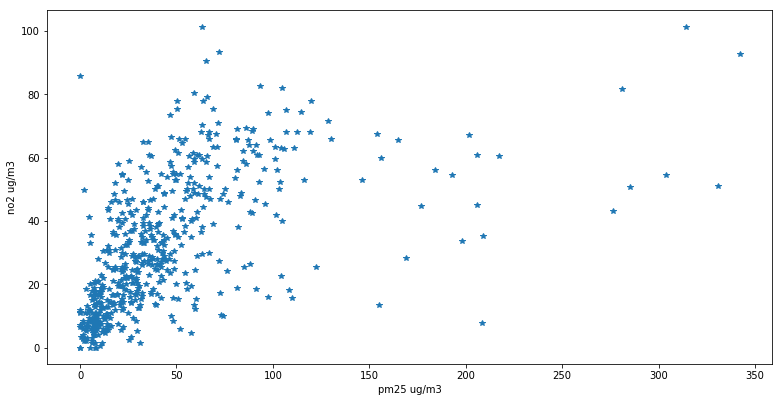

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\semi_supervised\label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\semi_supervised\label_propagation.py:201: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


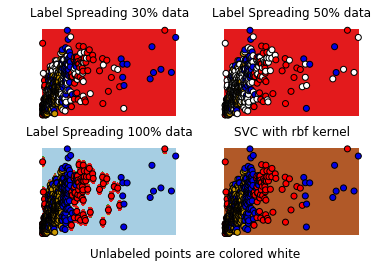

done


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
from sklearn.semi_supervised import label_propagation

rng = np.random.RandomState(0)


X = np.ndarray([df_pm25_no2.shape[0],2])
y = np.ndarray([df_pm25_no2.shape[0],])
y[mask_w_asia_2] = 0
y[mask_euro_2] = 1
y[mask_e_asia_2] = 2
X[:,0] = df_pm25_no2['pm25_median']
X[:,1] = df_pm25_no2['no2_median']

indx_sort = np.argsort(X[:,0])
# print(indx_sort)
X = X[indx_sort,:]
# print(X)

plt.figure(figsize=[13,6.5])
plt.plot(X[:,0],X[:,1],'*')
plt.xlabel('pm25 ug/m3')
plt.ylabel('no2 ug/m3')
plt.show()


# step size in the mesh
h = .5

y_30 = np.copy(y)
y_30[rng.rand(len(y)) < 0.3] = -1
y_50 = np.copy(y)
y_50[rng.rand(len(y)) < 0.5] = -1
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
ls30 = (label_propagation.LabelSpreading().fit(X, y_30),
        y_30)
ls50 = (label_propagation.LabelSpreading().fit(X, y_50),
        y_50)
ls100 = (label_propagation.LabelSpreading().fit(X, y), y)
rbf_svc = (svm.SVC(kernel='rbf').fit(X, y), y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['Label Spreading 30% data',
          'Label Spreading 50% data',
          'Label Spreading 100% data',
          'SVC with rbf kernel']

color_map = {-1: (1, 1, 1), 0: (0, 0, .9), 1: (1, 0, 0), 2: (.8, .6, 0)}

for i, (clf, y_train) in enumerate((ls30, ls50, ls100, rbf_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis('off')

    # Plot also the training points
    colors = [color_map[y] for y in y_train]
    plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='black')

    plt.title(titles[i])

plt.suptitle("Unlabeled points are colored white", y=0.1)
plt.show()
print('done')